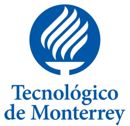

# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Estrategia de implementación de servicios tecnológicos**
### Tecnológico de Monterrey
### Prof Luis Eduardo Falcón Morales

## **9.2 Actividad**
## Actividad en Equipos - Semanas 9:

### **Modelos Transformer para textos en Español e Inglés**
____________

## Equipo 12
> - Francisco Javier Parga Garcia  **A01794380**
>
> - Enrique Hernández García **A01793727**
>
> - Matthias Sibrian Illescas **A01794249**
>
> - Alejandro Tomás Mackey **A01164338**
>
> - Ignacio Valdés Reyes **A0179326**




In [12]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# 1. Carga de datos 

In [2]:
# Cargar el archivo y crear el DataFrame
reviews = pd.read_csv('amazonbaby5000.csv', encoding='utf-8')
reviews.sample(5)

,review,rating
380,It's a simple book and my niece loved it becau...,1
1208,This box is pretty but wow........so expensive...,1
2957,My twins are at a stage where they chew on eve...,1
2124,"LOVE IT,QUICK LIL GADGET FOR WET SOILED CLOTHE...",1
328,We requested this system for the arrival of ou...,1


In [3]:
#Informacion general del dataframe
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  5000 non-null   object
 1   rating  5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.2+ KB


In [4]:
#Conteo del rating
reviews.rating.value_counts()

rating
1    3840
0    1160
Name: count, dtype: int64

# 2. Partición del dato

In [5]:
from sklearn.model_selection import train_test_split

# Particionar los datos en entrenamiento (60%) y prueba (40%), estratificando por rating
X_train, X_test, y_train, y_test = train_test_split(reviews['review'], reviews['rating'], test_size=0.4, stratify=reviews['rating'], random_state=42)

# Particionar el conjunto de entrenamiento en entrenamiento (75%) y validación (25%), estratificando por rating
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=42)

# 3. Modelo Transformer de HuggingFace

## a. Modelo predeterminado

In [6]:
from transformers import pipeline
from sklearn.metrics import accuracy_score

# Crear un pipeline de análisis de sentimiento
sentiment_analysis = pipeline("sentiment-analysis", model="siebert/sentiment-roberta-large-english", max_length=512, truncation=True, device=0)

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


In [7]:
%%time
# Analizar los comentarios del dataframe
results = sentiment_analysis(X_test.tolist(), 
                             batch_size=64)

# Definir el diccionario de mapeo
label_map = {'POSITIVE': 1, 'NEGATIVE': 0}

# Extraer las etiquetas predichas
y_pred = [label_map[result['label']] for result in results]

CPU times: total: 1min 47s
Wall time: 1min 48s


In [8]:
# Extraer las etiquetas reales
y_true = y_test.tolist()

# Calcular el accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {(accuracy)*100:.2f}%")

Accuracy: 94.05%


## b. DistilBERT

In [9]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch

In [10]:
# Crear un tokenizador de DistilBERT
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased', max_position_embeddings=512)

# Codificar los textos de cada conjunto
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(X_val.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True)

In [11]:
# Crear un dataset personalizado
class AmazonDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

# Crear los datasets de entrenamiento, validación y prueba
train_dataset = AmazonDataset(train_encodings, y_train.tolist())
val_dataset = AmazonDataset(val_encodings, y_val.tolist())
test_dataset = AmazonDataset(test_encodings, y_test.tolist())

In [12]:
# Crear un modelo de clasificación de secuencias con DistilBERT
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', max_position_embeddings=512).to("cuda")

# Crear un objeto de entrenamiento
training_args = TrainingArguments(
                              output_dir='./results', # directorio de salida
                              num_train_epochs=5, # número de épocas de entrenamiento
                              per_device_train_batch_size=32, # tamaño del lote por dispositivo durante el entrenamiento
                              per_device_eval_batch_size=64, # tamaño del lote para la evaluación
                              warmup_steps=500, # número de pasos de calentamiento para el programador de la tasa de aprendizaje
                              weight_decay=0.01, # fuerza de la decaimiento de peso
                              logging_dir='./logs', # directorio para almacenar los registros
                              logging_steps=10, # número de pasos para guardar los registros
                            )

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.

In [13]:
# Crear un entrenador
trainer = Trainer(
              model=model, # el modelo a entrenar
              args=training_args, # los argumentos de entrenamiento
              train_dataset=train_dataset, # el dataset de entrenamiento
              eval_dataset=val_dataset # el dataset de validación
            )

In [14]:
%%time

# Entrenar el modelo
trainer.train()

C:\Users\fgarcia24\Anaconda3\envs\mna\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
10,0.671800
20,0.653900
30,0.630200
40,0.600100
50,0.579700
60,0.513300
70,0.478800
80,0.467600
90,0.429100
100,0.372400


CPU times: total: 5min 13s
Wall time: 5min 16s


TrainOutput(global_step=355, training_loss=0.28417265096180877, metrics={'train_runtime': 316.1338, 'train_samples_per_second': 35.586, 'train_steps_per_second': 1.123, 'total_flos': 1490258234880000.0, 'train_loss': 0.28417265096180877, 'epoch': 5.0})

In [15]:
from datasets import load_metric

metric = load_metric('accuracy')

def compute_metrics(eval_pred):
  predictions, labels, summary = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return metric.compute(predictions=predictions, references=labels)


test_predict = trainer.predict(test_dataset)

accuracy = compute_metrics(test_predict)
print(f"Accuracy: {(accuracy['accuracy'])*100:.2f}%")

C:\Users\fgarcia24\AppData\Local\Temp\ipykernel_38100\250083128.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('accuracy')


Accuracy: 91.05%


## c. Comparación

> El modelo  default elegido `SiEBERT` logra un accuracy del **94%** sin ajustes (Este modelo `SiEBERT`, prefijo para “Sentiment in English”) es un punto de control afinado de RoBERTa-large (Liu et al. 2019). Permite un análisis de sentimiento binario confiable para varios tipos de texto en inglés.), mientras que `DistilBERT` entrenado con 60% de los comentarios en Amazon logra un **91%**

# 4. BETO-sentiment-analysis

## Traducción de los comentarios

In [16]:
# Importar la librería transformers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Cargar el tokenizador y el modelo pre-entrenados
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-es")
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-es")

# Crear una pipeline de traducción
translator = pipeline("translation_en_to_es", model=model, tokenizer=tokenizer, max_length=512, truncation=True, device=0)

In [17]:
%%time
# Aplicar la pipeline a los comentarios
traducciones = translator(reviews['review'].values.tolist(),
                          batch_size=32)

Your input_length: 505 is bigger than 0.9 * max_length: 512. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
Your input_length: 512 is bigger than 0.9 * max_length: 512. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
Your input_length: 512 is bigger than 0.9 * max_length: 512. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
Your input_length: 512 is bigger than 0.9 * max_length: 512. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
Your input_length: 512 is bigger than 0.9 * max_length: 512. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
Your input_length: 512 is bigger than 0.9 * max_length: 512. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
Your input_length: 493 is bigger than 0.9 * max_length: 512. You

CPU times: total: 17min 27s
Wall time: 18min 25s


In [18]:
traducciones[-1]['translation_text']

'Compré este pensamiento que haría mi vida un poco más fácil. Mi niño le gusta encender y apagar la luz en su cuarto de baño al entrar y salir de la habitación, lo que significaba que tendría que recogerla cada vez. Sé que podía hacerlo por ella, pero quiero que aprenda cómo funcionan las cosas y que puede hacer las cosas por su cuenta. No sólo esto hizo mi vida más fácil, le encanta mostrar a los abuelos y tías cómo puede encender y apagar la luz.Leí una reseña que decía que era una pieza de plástico endeble.Quizás hicieron mejoras desde que ese crítico compró la suya, sino que mi experiencia es que estoy muy satisfecho con la construcción de la pieza.El brazo de plástico es muy rígido y cuelga (restos) a unos 3/4 de pulgada de distancia de la pared, por lo que no raspa la pared con todo el arriba y abajo.Los tornillos con las mangas que vino con un accesorio sólido en la placa de pared, y la acción es suave y consistente.'

In [19]:
reviews['review'].values[-1]

"I bought this thinking it would make my life a little easier.  My toddler likes to turn the light in her bathroom on and off upon entering and leaving the room, which meant I would have to pick her up every time.  I know, I could do it for her, but I want her to learn how things work and that she can do things on her own.  Not only did this make my life easier, she loves showing grandparents and aunts how she can turn the light on and off.I read one review that said this was a real flimsy piece of plastic.  Maybe they made upgrades since that reviewer purchased theirs, but my experience is that I am very pleased with the construction of the piece.  The plastic arm is very rigid and it hangs (rests) about 3/4 of a inch away from the wall, so it doesn't scratch up the wall with all the up and down.  The screws with sleeves that it came with make for a solid attachment at the wall plate, and the action is smooth and consistent.It does glow in the dark if it has been exposed to light for 

In [20]:
traducciones_list = [traduccion['translation_text'] for traduccion in traducciones]

reviews = reviews.assign(es=traducciones_list)
reviews.sample(5)

,review,rating,es
1501,This toy is so amazing - my friends had raved ...,1,Este juguete es tan increíble - mis amigos hab...
2586,"this was a great price for what i got, if you ...",1,"Este fue un gran precio por lo que tengo, si v..."
2653,"I think the description is very accurate, It's...",1,"Creo que la descripción es muy precisa, es gen..."
1055,I have this car seat for a year and its still ...,1,Tengo esta silla de coche por un año y todavía...
705,I really like this book. You can show your bab...,1,Realmente me gusta este libro. Puedes mostrar ...


In [21]:
reviews.to_csv('reviews_es.csv', index=False)

Las traducciones son buenas en general. Lo que pudimos notar es que algunas palabras son traducidas sin tomar en cuenta el contexto completo. A pesar de esto, las traducciones conservan la idea principal en el paso del inglés al español. Los errores son mínimos y no crean confusión.

# 5.  Modelo Transformer “pysentimiento”, basado en BETO

In [13]:
reviews = pd.read_csv('reviews_es.csv', encoding='utf-8')
reviews.head()

,review,rating,es
0,I think it is more Expensive than drugstore th...,0,Creo que es más caro que la farmacia que sólo ...
1,"When I saw this on Amazon, I put it into my wi...",1,"Cuando vi esto en Amazon, lo puse en mi lista ..."
2,We really like these valances. They have such...,1,Realmente nos gustan estos valances. Tienen pe...
3,No light emits from the night light. They pain...,0,No hay luz que emita de la luz nocturna. Lo pi...
4,I was really hoping for this to be a conventie...,0,Realmente esperaba que esto fuera un dispensad...


In [22]:
from pysentimiento import create_analyzer

sentiment_classifier_es = create_analyzer(task="sentiment", lang="es")

In [23]:
%%time
# Aplicar la pipeline a los comentarios
sentimientos = sentiment_classifier_es.predict(traducciones_list)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

CPU times: total: 35.2 s
Wall time: 36.3 s


In [24]:
sentimientos[0:10]

[AnalyzerOutput(output=NEU, probas={NEU: 0.516, NEG: 0.453, POS: 0.031}),
 AnalyzerOutput(output=POS, probas={POS: 0.927, NEU: 0.068, NEG: 0.004}),
 AnalyzerOutput(output=POS, probas={POS: 0.976, NEU: 0.021, NEG: 0.003}),
 AnalyzerOutput(output=NEU, probas={NEU: 0.699, NEG: 0.207, POS: 0.094}),
 AnalyzerOutput(output=NEG, probas={NEG: 0.702, NEU: 0.293, POS: 0.006}),
 AnalyzerOutput(output=POS, probas={POS: 0.975, NEU: 0.023, NEG: 0.002}),
 AnalyzerOutput(output=NEU, probas={NEU: 0.729, NEG: 0.180, POS: 0.091}),
 AnalyzerOutput(output=POS, probas={POS: 0.482, NEU: 0.468, NEG: 0.051}),
 AnalyzerOutput(output=NEG, probas={NEG: 0.799, NEU: 0.193, POS: 0.008}),
 AnalyzerOutput(output=POS, probas={POS: 0.959, NEU: 0.037, NEG: 0.004})]

In [25]:
# Definir el diccionario de mapeo
label_map_es = {'POS': 1, 'NEG': 0, 'NEU':0.5}

# Extraer las etiquetas predichas
sentimientos_es_code = [label_map_es[result.output] for result in sentimientos]

reviews = reviews.assign(es_sent=sentimientos_es_code)
reviews.sample(5)

,review,rating,es,es_sent
1501,This toy is so amazing - my friends had raved ...,1,Este juguete es tan increíble - mis amigos hab...,1.0
2586,"this was a great price for what i got, if you ...",1,"Este fue un gran precio por lo que tengo, si v...",1.0
2653,"I think the description is very accurate, It's...",1,"Creo que la descripción es muy precisa, es gen...",1.0
1055,I have this car seat for a year and its still ...,1,Tengo esta silla de coche por un año y todavía...,1.0
705,I really like this book. You can show your bab...,1,Realmente me gusta este libro. Puedes mostrar ...,1.0


In [16]:
reviews = pd.read_csv('reviews_es_sent.csv', encoding='utf-8')
reviews['es_sent'].value_counts()

1.0    3103
0.5    1109
0.0     788
Name: es_sent, dtype: int64

In [19]:
reviews.dtypes

review      object
rating       int64
es          object
es_sent    float64
dtype: object

In [20]:
reviews = reviews.astype({'rating': float})

In [34]:
reviews = reviews.loc[reviews['es_sent'] != 0.5]

In [37]:
y_true = reviews['rating'].values
y_pred = reviews['es_sent'].values

In [38]:
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {(accuracy)*100:.2f}%")

Accuracy: 90.75%


Para comparar el resultado obtenido a través del análisis de sentimiento, se tuvo que considerar exclusivamente los casos en los que la clase resultante aparecía en la etiqueta original. Es decir, para comparar si un sentimiento es positivo o negativo, se excluyó los escenarios en donde se cuenta con un resultado neutro. Tomando esto en cuenta, se tiene una exactitud (accuracy) del 90.75%, lo cual es bastante favorable.

# 6. Resumen de resultados

| Modelo predeterminado | DistilBERT | Pysentimiento |
| -------- | -------- | -------- |
| 94.05%   | 91.05%   | 90.75%   |


En la tabla anterior se muestra un resumen de los resultados obtenidos para los tres modelos utilizados. El primero de ellos consiste en el modelo Transformer Hugging Face sin ajuste de parámetros y sin reentrenamiento. El segundo consiste en el modelo entrenado exclusivamente con la data de los comentarios positivos y negativos del dataset de Amazon, En el tercer modelo, se utilizó el modelo Pysentimiento para el análisis de sentimiento. El primero de ellos tuvo una exactitud (accuracy) de 94.05%, el segundo, de 91.05%, mientras que el tercero, de 90.75%. 

Estas diferencias se deben grandemente a que DistilBERT se entrenó usando solamente los comentarios del dataset utilizado. Por ello, se hizo un reajuste de parámetros para conseguir la mejor iteración posible. Por otro lado, el resultado de Pysentimiento hizo uso de los resultados traducidos al español desde el inglés. Esto crea un error asociado a la traducción adicional que se debe considerar. Sin embargo, a pesar de ello, se tuvo un desempeño alto de exactitud. Esto sugiere que estos modelos son bastante robustos para su utilización en soluciones diversas, ya sea reentrenando para el caso de uso, usándolos ya entrenados, e incluso traduciendo los textos a utilizar entre distintos idiomas.